In [1]:
import os
import re
import random
import pandas as pd
import matplotlib.pyplot as plt

from mecab import MeCab
from konlpy.tag import Okt
from collections import Counter

In [2]:
data_path = "../dataset"

train_df = pd.read_csv(f"{data_path}/cleaned_train.csv")
valid_df = pd.read_csv(f"{data_path}/cleaned_dev.csv")

In [3]:
print("Train DataFrame")
print(train_df.shape)
print(train_df.columns)

print("\nValid DataFrame")
print(valid_df.shape)
print(valid_df.columns)

Train DataFrame
(12457, 4)
Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

Valid DataFrame
(499, 4)
Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')


# 1.Sample Row 확인

In [4]:
idx = random.randint(0, train_df.shape[0]-1)
sample = train_df.iloc[idx]
print(sample, "\n")

print(f"전체 대화 :\n{sample['dialogue']} \n")
print(f"요약 내용 :\n{sample['summary']}, \n")
print(f"대화 주제 :\n {sample['topic']}, \n")

fname                                                train_76
dialogue    #Person1#: 아, 아니! 나는 정확히 7시에 그녀를 만나야 해. 지금 몇 시...
summary     #Person1#은 데이트를 가지만 어디로 갈지 아직 결정하지 못했다. #Perso...
topic                                                   일상 대화
Name: 76, dtype: object 

전체 대화 :
#Person1#: 아, 아니! 나는 정확히 7시에 그녀를 만나야 해. 지금 몇 시야?
#Person2#: 여섯시 반이야.
#Person1#: 나는 준비해야겠어.
#Person2#: 어디 가는 거야?
#Person1#: 아직 정하지 못했어. 아마 식당으로 갈 수도 있고, 아니면 먼저 영화를 볼 수도 있어.
#Person2#: 클래식 영화 축제에 시민 케인을 보러 가는 건 어때? 정말 좋다고 들었어.
#Person1#: 아, 그럴지도 모르겠네. 사이코도 상영 중이야. 그것도 정말 좋다고 들었어.
#Person2#: 피가 많이 나오는 공포 영화를 좋아한다면 말이야. 개인적으로는 나는 그렇지 않아. 그럼, 나 진짜 가야겠어. 내일 수영하러 갈래?
#Person1#: 가고 싶지만, 스튜디오에 가서 일을 해야 할 수도 있어. 내가 아침에 제일 먼저 알려줘도 될까?
#Person2#: 그래. 괜찮아.
#Person1#: 아, 전화가 왔네. 트레이시일 거야.
#Person2#: 그럼, 나 가야겠다. 오늘 밤 잘 보내.
#Person1#: 고마워. 내일 연락할게. 

요약 내용 :
#Person1#은 데이트를 가지만 어디로 갈지 아직 결정하지 못했다. #Person2#는 시민 케인을 보는 것을 제안한다. #Person1#과 #Person2#는 내일 수영하러 가기로 결정한다., 

대화 주제 :
 일상 대화, 



# 2.데이터 길이

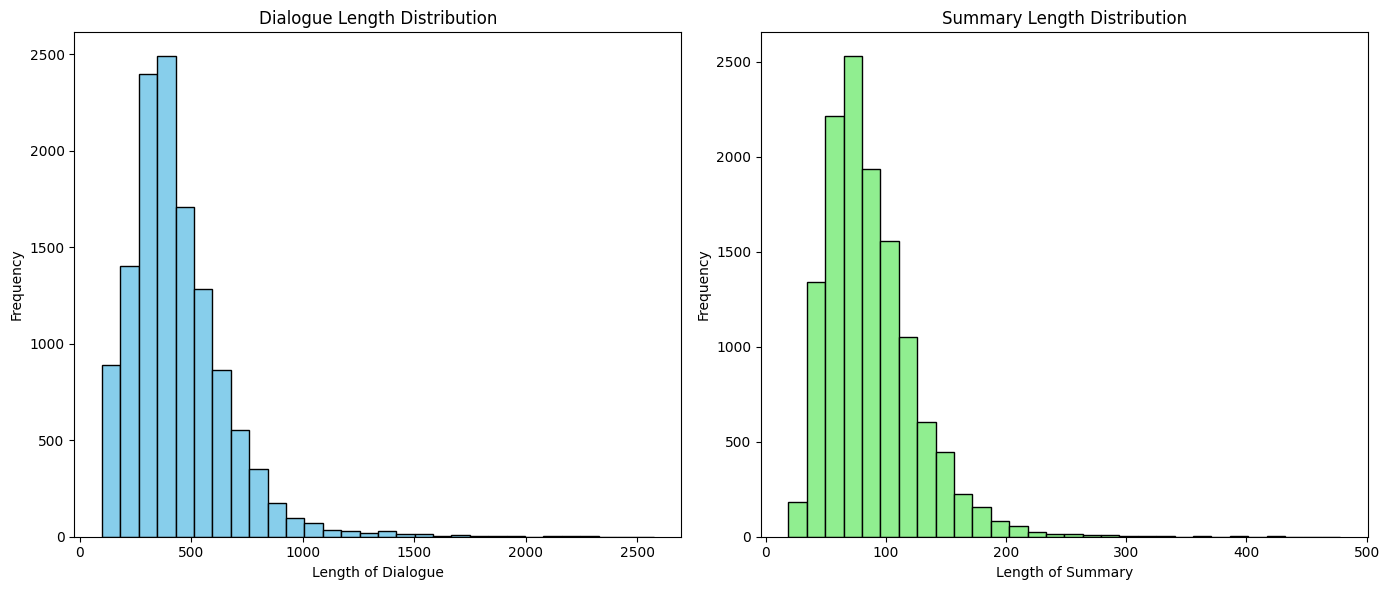

In [5]:
# dialogue와 summary의 길이를 계산
train_df['dialogue_length'] = train_df['dialogue'].apply(len)
train_df['summary_length'] = train_df['summary'].apply(len)

# 시각화
plt.figure(figsize=(14, 6))

# Dialogue 길이 시각화
plt.subplot(1, 2, 1)
plt.hist(train_df['dialogue_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Dialogue Length Distribution')
plt.xlabel('Length of Dialogue')
plt.ylabel('Frequency')

# Summary 길이 시각화
plt.subplot(1, 2, 2)
plt.hist(train_df['summary_length'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Summary Length Distribution')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# min, max, mode 길이를 계산하는 함수 정의
def get_length_stats(column):
    min_length = column.min()
    max_length = column.max()
    mode_length = column.mode()[0]
    return min_length, max_length, mode_length

# dialogue와 summary의 길이에 대한 통계 계산
dialogue_min, dialogue_max, dialogue_mode = get_length_stats(train_df['dialogue_length'])
summary_min, summary_max, summary_mode = get_length_stats(train_df['summary_length'])

dialogue_stats = {
    'Dialogue': {
        'Min Length': dialogue_min,
        'Max Length': dialogue_max,
        'Mode Length': dialogue_mode
    },
    'Summary': {
        'Min Length': summary_min,
        'Max Length': summary_max,
        'Mode Length': summary_mode
    }
}

print(dialogue_stats)

{'Dialogue': {'Min Length': 99, 'Max Length': 2575, 'Mode Length': 316}, 'Summary': {'Min Length': 19, 'Max Length': 478, 'Mode Length': 63}}


# 3.특수 문자열

In [7]:
train_df['is_train'] = 1
valid_df['is_train'] = 0
total_df = pd.concat([train_df, valid_df], ignore_index=True)

In [8]:
# 특수 문자열 패턴 찾기 함수
def find_special_strings(text):
    return re.findall(r'#\w+#', text)

total_df['dialogue_special_strings'] = total_df['dialogue'].apply(find_special_strings)
total_df['summary_special_strings'] = total_df['summary'].apply(find_special_strings)

# total_df[['dialogue_special_strings', 'summary_special_strings']].head()
unique_dialogue_strings = set([item for sublist in total_df['dialogue_special_strings'] for item in sublist])
unique_summary_strings = set([item for sublist in total_df['summary_special_strings'] for item in sublist])

print(unique_dialogue_strings)
print(unique_summary_strings)

{'#SSN#', '#CardNumber#', '#CarNumber#', '#PassportNumber#', '#Movietitle#', '#DateOfBirth#', '#Person2#', '#Person7#', '#Email#', '#Reaction#', '#Address#', '#Person4#', '#PhoneNumber#', '#Person6#', '#Person3#', '#Person5#', '#Person1#'}
{'#Person2#', '#Person3#', '#Person7#', '#Person6#', '#Person4#', '#Person1#'}


# 4.형태소 분석

In [9]:
## 분석하기 전에 [#문자열#:]을 제거한다.
def remove_speaker_tags(text):
    return re.sub(r'#\w+#:', '', text)

In [10]:
## 개행 문자 제거.
def remove_newlines(text):
    # 개행 문자를 문장부호 뒤에 공백과 함께 추가
    text = re.sub(r'([.?!])\n', r'\1 ', text)

    # 개행 문자가 남아있는 경우 제거
    return text.replace('\n', ' ')

In [11]:
mecab = MeCab()

# Dialogue와 Summary 형태소 분석
total_df['cleaned_dialogue'] = total_df['dialogue'].apply(lambda x: remove_newlines(remove_speaker_tags(x)))
total_df['cleaned_summary'] = total_df['summary'].apply(lambda x: remove_newlines(remove_speaker_tags(x)))

total_df['dialogue_morphs'] = total_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))
total_df['summary_morphs'] = total_df['cleaned_summary'].apply(lambda x: mecab.morphs(x))

total_df.head()

,fname,dialogue,summary,topic,dialogue_length,summary_length,is_train,dialogue_special_strings,summary_special_strings,cleaned_dialogue,cleaned_summary,dialogue_morphs,summary_morphs
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기,575.0,107.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요? 건강검진을 ...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...","[안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...","[스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,..."
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신,457.0,61.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 파커 부인, 어떻게 지내셨나요? 안녕하세요, 피터스 박사님. 잘 지...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,"[안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...","[파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ..."
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기,340.0,62.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#]","실례합니다, 열쇠 한 묶음 보셨나요? 어떤 종류의 열쇠인가요? 5개의 열쇠와 ...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...","[실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...","[#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,..."
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다,378.0,78.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#, #Person1#]","왜 너는 여자친구가 있다는 걸 말해주지 않았어? 미안해, 너가 이미 알고 있다고...",#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,"[왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...","[#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친..."
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스,314.0,51.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,"[안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...","[말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을..."


## 자음만 사용된 경우
dialogue에는 ㅋㅋ와 같은 단어가 포함되어 있지만 summary에는 아무것도 없다.

In [12]:
## "ㅋㅋ", "ㅎㅎ"와 같은 구어체에서 벗어나는 형태가 있는지 확인.
def find_special_patterns(morphs):
    consonant_pattern = re.compile(r'^[ㄱ-ㅎ]{2,}$')  # 자음이 최소 2번 이상 반복되는 경우만

    return [morph for morph in morphs if consonant_pattern.match(morph)]

In [13]:
# 형태소 분석
total_df['dialogue_morphs'] = total_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))
total_df['summary_morphs'] = total_df['cleaned_summary'].apply(lambda x: mecab.morphs(x))

In [14]:
# 특이 패턴 찾기
total_df['dialogue_special_patterns'] = total_df['dialogue_morphs'].apply(find_special_patterns)
total_df['summary_special_patterns'] = total_df['summary_morphs'].apply(find_special_patterns)

# 특이 패턴이 포함된 Dialogue 행 필터링
dialogue_special_rows = total_df[total_df['dialogue_special_patterns'].apply(lambda x: len(x) > 0)]
summary_special_rows = total_df[total_df['summary_special_patterns'].apply(lambda x: len(x) > 0)]

dialogue_special_rows_info = dialogue_special_rows[['dialogue', 'dialogue_special_patterns']].reset_index()
summary_special_rows_info = summary_special_rows[['summary', 'summary_special_patterns']].reset_index()

In [15]:
print("Dialogue with Special Patterns:")
print(dialogue_special_rows_info)

print("Summary with Special Patterns:")
print(summary_special_rows_info)

Dialogue with Special Patterns:
Empty DataFrame
Columns: [index, dialogue, dialogue_special_patterns]
Index: []
Summary with Special Patterns:
Empty DataFrame
Columns: [index, summary, summary_special_patterns]
Index: []


In [16]:
total_df.head()

,fname,dialogue,summary,topic,dialogue_length,summary_length,is_train,dialogue_special_strings,summary_special_strings,cleaned_dialogue,cleaned_summary,dialogue_morphs,summary_morphs,dialogue_special_patterns,summary_special_patterns
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기,575.0,107.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요? 건강검진을 ...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...","[안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...","[스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...",[],[]
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신,457.0,61.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 파커 부인, 어떻게 지내셨나요? 안녕하세요, 피터스 박사님. 잘 지...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,"[안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...","[파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...",[],[]
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기,340.0,62.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#]","실례합니다, 열쇠 한 묶음 보셨나요? 어떤 종류의 열쇠인가요? 5개의 열쇠와 ...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...","[실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...","[#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...",[],[]
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다,378.0,78.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#, #Person1#]","왜 너는 여자친구가 있다는 걸 말해주지 않았어? 미안해, 너가 이미 알고 있다고...",#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,"[왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...","[#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...",[],[]
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스,314.0,51.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,"[안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...","[말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...",[],[]


## 반복되는 글자가 있는 데이터

In [17]:
# 반복되는 글자 패턴을 찾는 함수
def find_repeated_patterns(text):
    # 반복되는 글자 패턴을 찾기 위한 정규식 (같은 글자가 3번 이상 반복)
    # repeated_pattern = re.compile(r'(.)\1{2,}')
    repeated_pattern = re.compile(r'([가-힣])\1{2,}')  # 동일한 한글 글자가 연속적으로 2번 이상 반복

    return [match.group(0) for match in repeated_pattern.finditer(text)]

In [18]:
# 반복되는 글자 패턴 찾기
total_df['dialogue_repeated_patterns'] = total_df['cleaned_dialogue'].apply(find_repeated_patterns)
total_df['summary_repeated_patterns'] = total_df['cleaned_summary'].apply(find_repeated_patterns)

# 반복되는 패턴이 포함된 Dialogue 행 필터링
dialogue_repeated_rows = total_df[total_df['dialogue_repeated_patterns'].apply(lambda x: len(x) > 0)]
summary_repeated_rows = total_df[total_df['summary_repeated_patterns'].apply(lambda x: len(x) > 0)]

dialogue_repeated_rows_info = dialogue_repeated_rows[['dialogue', 'dialogue_repeated_patterns']].reset_index()
summary_repeated_rows_info = summary_repeated_rows[['summary', 'summary_repeated_patterns']].reset_index()

In [19]:
total_df.head()

,fname,dialogue,summary,topic,dialogue_length,summary_length,is_train,dialogue_special_strings,summary_special_strings,cleaned_dialogue,cleaned_summary,dialogue_morphs,summary_morphs,dialogue_special_patterns,summary_special_patterns,dialogue_repeated_patterns,summary_repeated_patterns
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기,575.0,107.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요? 건강검진을 ...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...","[안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...","[스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...",[],[],[],[]
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신,457.0,61.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕하세요, 파커 부인, 어떻게 지내셨나요? 안녕하세요, 피터스 박사님. 잘 지...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,"[안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...","[파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...",[],[],[],[]
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기,340.0,62.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#]","실례합니다, 열쇠 한 묶음 보셨나요? 어떤 종류의 열쇠인가요? 5개의 열쇠와 ...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...","[실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...","[#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...",[],[],[],[]
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다,378.0,78.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","[#Person1#, #Person2#, #Person1#]","왜 너는 여자친구가 있다는 걸 말해주지 않았어? 미안해, 너가 이미 알고 있다고...",#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,"[왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...","[#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...",[],[],[],[]
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스,314.0,51.0,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",[],"안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,"[안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...","[말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...",[],[],[],[]


In [20]:
print("Dialogue with Repeated Patterns:")
print(dialogue_repeated_rows_info)

print("Summary with Repeated Patterns:")
print(summary_repeated_rows_info)

Dialogue with Repeated Patterns:
Empty DataFrame
Columns: [index, dialogue, dialogue_repeated_patterns]
Index: []
Summary with Repeated Patterns:
Empty DataFrame
Columns: [index, summary, summary_repeated_patterns]
Index: []


# 한글 이외의 문자를 포함

In [21]:
# 한글이 아닌 다른 문자를 찾는 함수
def find_non_hangul_patterns(text):
    # 한글, 공백, 기본 구두점(.,?!, 공백)을 제외한 모든 문자 또는 연속된 점(...) 패턴을 찾음
    non_hangul_pattern = re.compile(r'[^가-힣\s.,?!]|(?<!\.)\.\.+')
    return non_hangul_pattern.findall(text)

In [22]:
# 한글 이외의 다른 문자가 포함된 패턴 찾기
total_df['dialogue_non_hangul_patterns'] = total_df['cleaned_dialogue'].apply(find_non_hangul_patterns)
total_df['summary_non_hangul_patterns'] = total_df['cleaned_summary'].apply(find_non_hangul_patterns)

dialogue_non_hangul_rows_info = total_df[total_df['dialogue_non_hangul_patterns'].apply(lambda x: len(x) > 0)][['dialogue', 'dialogue_non_hangul_patterns']]
print(dialogue_non_hangul_rows_info)

                                                dialogue  \
0      #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1      #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2      #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
4      #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   
6      #Person1#: 여기 도착했습니다.\n#Person2#: 감사합니다. 요금은 얼...   
...                                                  ...   
12947  #Person1#: 인터넷에서 빌 게이츠의 집을 본 적이 있나요? \n#Person...   
12949  #Person1#: 실례합니다, 지금 8인용 테이블이 있나요? \n#Person2#...   
12950  #Person1#: 나는 완전히 내 상사에게 지쳤어. 그는 그의 성차별적인 발언으로...   
12951  #Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \n#Per...   
12954  #Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...   

                            dialogue_non_hangul_patterns  
0                                                    [5]  
1                                     [B, 1, 4, A, 1, 5]  
2                                                    [5]  
4                                          

In [23]:
unique_patterns = set()

for index in range(dialogue_non_hangul_rows_info.shape[0]):
    patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
    unique_patterns.update(patterns)

for pattern in unique_patterns:
    print(f"Pattern: {pattern}")

Pattern: L
Pattern: R
Pattern: g
Pattern: n
Pattern: /
Pattern: P
Pattern: s
Pattern: Y
Pattern: %
Pattern: $
Pattern: q
Pattern: 0
Pattern: e
Pattern: 2
Pattern: K
Pattern: M
Pattern: =
Pattern: 8
Pattern: H
Pattern: B
Pattern: U
Pattern: T
Pattern: b
Pattern: ㅣ
Pattern: w
Pattern: —
Pattern: 1
Pattern: ’
Pattern: i
Pattern: 9
Pattern: f
Pattern: E
Pattern: 5
Pattern: N
Pattern: x
Pattern: a
Pattern: 7
Pattern: u
Pattern: 6
Pattern: [
Pattern: F
Pattern: h
Pattern: :
Pattern: Q
Pattern: A
Pattern: Z
Pattern: p
Pattern: "
Pattern: ....
Pattern: v
Pattern: ~
Pattern: ‘
Pattern: &
Pattern: G
Pattern: 3
Pattern: C
Pattern: O
Pattern: J
Pattern: r
Pattern: k
Pattern: l
Pattern: #
Pattern: D
Pattern: z
Pattern: I
Pattern: ​
Pattern: 4
Pattern: W
Pattern: S
Pattern: \
Pattern: c
Pattern: '
Pattern: V
Pattern: d
Pattern: j
Pattern: +
Pattern: –
Pattern: o
Pattern: y
Pattern: X
Pattern: m
Pattern: t


In [24]:
def replace_movie_title(dialogue):
    # <문자열> 패턴을 #Movietitle#로 변경
    return re.sub(r'<[^>]+>', '#Movietitle#', dialogue)

# <문자열>을 포함하는 행을 찾음
rows_with_movie_title = total_df[total_df['dialogue'].str.contains(r'<[^>]+>')].index.tolist()

for row in rows_with_movie_title:
    original_dialogue = total_df.loc[row, 'dialogue']
    updated_dialogue = replace_movie_title(original_dialogue)
    print(f"Row {row}:")
    print("Before:", original_dialogue)
    print("After:", updated_dialogue)
    total_df.loc[row, 'dialogue'] = updated_dialogue

total_df.loc[rows_with_movie_title, ['dialogue']]

,dialogue


In [25]:
# 함수: 대화 내에서 (문자열) 또는 [문자열]을 #Reaction#으로 대체
def replace_reaction(dialogue):
    # (문자열) 또는 [문자열] 패턴을 #Reaction#으로 변경
    dialogue = re.sub(r'\(.*?\)|\[.*?\]', '#Reaction#', dialogue)
    return dialogue

# (문자열) 또는 [문자열]을 포함하는 행을 찾음
rows_with_reaction = total_df[total_df['dialogue'].str.contains(r'\(.*?\)|\[.*?\]')].index.tolist()

for row in rows_with_reaction:
    original_dialogue = total_df.loc[row, 'dialogue']
    updated_dialogue = replace_reaction(original_dialogue)
    print(f"Row {row}:")
    print("Before:", original_dialogue)
    print("After:", updated_dialogue)
    total_df.loc[row, 'dialogue'] = updated_dialogue

total_df.loc[rows_with_reaction, ['dialogue']]

,dialogue


In [26]:
with open('output.txt', 'w', encoding='utf-8') as file:
    for index in range(dialogue_non_hangul_rows_info.shape[0]):
        patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
        dialogue = dialogue_non_hangul_rows_info.iloc[index]['dialogue']
        file.write(f"Index {index}:\nPatterns: {patterns}\nDialogue: {dialogue}\n\n")